# Milestone 3 : Proposition de mots clés – Approche non supervisée

### Libraries

In [35]:
import pickle
import numpy as np
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

pd.set_option('display.max_colwidth', None)  # Affiche la largeur maximale de la colonne sans troncature




### Load preprocessed Data

In [36]:
import pickle

# Load the CountVectorizer
with open('cv_vectorizer.pkl', 'rb') as file:
    cv = pickle.load(file)

# Load the transformed training data
with open('X_train_cv.pkl', 'rb') as file:
    X_train_cv = pickle.load(file)

# Load the transformed testing data
with open('X_test_cv.pkl', 'rb') as file:
    X_test_cv = pickle.load(file)

# Load the feature names
with open('features_names_cv.pkl', 'rb') as file:
    features_names_cv = pickle.load(file)

Introducing LDA#
LDA is another topic model that we haven't covered yet because it's so much slower than NMF. Even if it's better it's just painful to sit around for minutes waiting for our computer to give you a result, when NMF has it done in under a second.

With that complaining out of the way, let's give LDA a shot. The code looks almost exactly like NMF, we just use something else to build our model.

There's one big difference: LDA has TF-IDF built in, so we need to use a CountVectorizer as the vectorizer instead of a TfidfVectorizer. If you don't do this your results will be tragic.

### Optimisation du nombre de topics (perplexité)

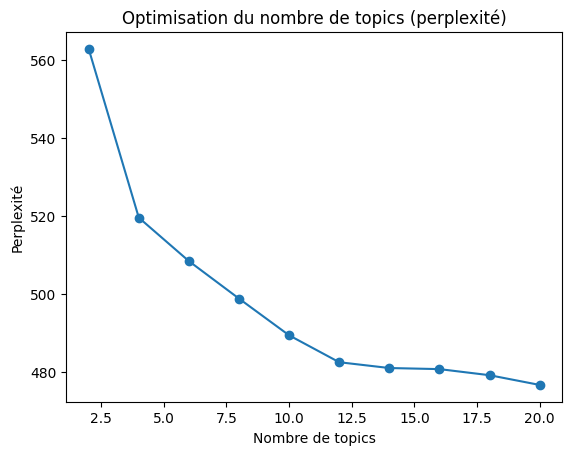

In [37]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Liste des valeurs de n_components à tester
n_topics_range = list(range(2, 21, 2))
perplexities = []

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X_train_cv)
    perplexities.append(lda.perplexity(X_train_cv))

plt.plot(n_topics_range, perplexities, marker='o')
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité")
plt.title("Optimisation du nombre de topics (perplexité)")
plt.show()


### CountVectorizer + LDA Model

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize the LDA model
lda = LatentDirichletAllocation(n_components=11, random_state=0, learning_decay= 0.9)  # Set the number of topics

# Fit the LDA model using the training data
lda.fit(X_train_cv)

# Transform the training data to LDA topic-space
X_train_lda = lda.transform(X_train_cv)

# Transform the testing data to LDA topic-space
X_test_lda = lda.transform(X_test_cv)

In [39]:
# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n--- Topic {topic_idx + 1} ---")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top 10 words for each topic
display_topics(lda, features_names_cv, 15)


--- Topic 1 ---
page, html, form, use, work, jquery, div, javascript, ie, script, user, ajax, link, click, im

--- Topic 2 ---
run, use, application, windows, test, error, set, try, work, server, thread, java, visual, log, get

--- Topic 3 ---
image, use, im, view, memory, size, load, get, iphone, code, content, foo, try, work, png

--- Topic 4 ---
table, database, sql, use, data, select, query, id, like, row, store, create, field, value, key

--- Topic 5 ---
string, value, var, return, data, function, get, new, php, array, text, code, use, character, xml

--- Topic 6 ---
file, use, project, web, service, xml, .net, add, asp, directory, create, system, path, get, im

--- Topic 7 ---
text, window, button, control, bind, event, use, add, width, change, color, work, get, click, want

--- Topic 8 ---
java, self, import, error, view, search, org, eclipse, line, controller, def, name, word, style, get

--- Topic 9 ---
class, public, object, new, get, method, private, void, return, call, typ

In [40]:
import pyLDAvis
import pyLDAvis.lda_model
import pandas as pd


pyLDAvis.enable_notebook()

# Prepare the data for visualization
lda_vis_data = pyLDAvis.lda_model.prepare(
    lda,                  # fitted LDA model
    X_train_cv,          # document-term matrix from CountVectorizer
    vectorizer=cv,       # CountVectorizer instance
    mds='tsne'           # t-SNE for dimensionality reduction
)

# Display the interactive interface
pyLDAvis.display(lda_vis_data)


### Evaluation

#### Perplexity score

In [41]:
train_perplexity = lda.perplexity(X_train_cv)
print(f"Perplexité sur les données d'entraînement : {train_perplexity}")
test_perplexity = lda.perplexity(X_test_cv)
print(f"Perplexité sur les données de test : {test_perplexity}")

Perplexité sur les données d'entraînement : 488.01641368885925
Perplexité sur les données de test : 591.3965754352074


#### Coherence score

In [42]:
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

X_train = pd.read_csv("C:/Users/lzeferino/Documents/GitHub/NLP-Multi-Label-Text-Classification-for-Stack-Overflow-Tag-Prediction/X_train.csv")

# Créer une liste de listes de mots pour chaque document (X_train_tokens)
X_train_tokens = [doc.split() for doc in X_train['combined_text_bow']] 

# Créer un dictionnaire pour Gensim
dictionary = Dictionary(X_train_tokens)

# Obtenir les mots les plus probables pour chaque topic
top_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_words.append([features_names_cv[i] for i in topic.argsort()[:-10 - 1:-1]])  # Top 10 words per topic

# Calculer la cohérence
coherence_model = CoherenceModel(topics=top_words, texts=X_train_tokens, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score : {coherence_score}")

Coherence Score : 0.5255027309909903


#### Evaluation métier - Taux de couverture

In [43]:
import pandas as pd
import numpy as np

# Calcul des probabilités de topics pour chaque observation // probabilités d'appartenance de chaque question aux topics
topic_probabilities_train = lda.transform(X_train_cv)
topic_probabilities_test = lda.transform(X_test_cv)

# Associe chaque observation au topic dominant (celui avec la probabilité la plus élevée)
dominant_topic_train = np.argmax(topic_probabilities_train, axis=1)
dominant_topic_test = np.argmax(topic_probabilities_test, axis=1)

# Affichez les mots-clés principaux de chaque topic
def display_topics(model, feature_names, no_top_words=10):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_words

# Obtenez les mots-clés pour chaque topic
topic_words = display_topics(lda, features_names_cv, 10)

# Créez un DataFrame pour les résultats d’entraînement
results_train = pd.DataFrame({
    'Document': X_train_tokens,  # Texte original de chaque observation
    'Dominant_Topic': dominant_topic_train,
    'Topic_Words': [topic_words[topic] for topic in dominant_topic_train],
    'Topic_Probabilities': [topic_probabilities_train[i] for i in range(X_train_cv.shape[0])]
})


# Affichez les premières lignes pour vérification
results_train.head(2)


,Document,Dominant_Topic,Topic_Words,Topic_Probabilities
0,"[load, uiview, use, nib, file, create, interface, builder, im, try, something, bite, elaborate, something, possible, challenge, experts, forum, pack, lot, guy, im, create, questionnaire, component, want, load, navigationcontoller, questionmanagerviewcontroller, component, empty, uiviewcontroller, load, different, view, depend, question, need, answer, way, im, create, questionview, object, uiview, subclass, define, iboutlets, create, use, interface, builder, questionview, xib, problem, probably, set, uiviewcontroller, uiview, class, questionview, link, outlets, view, component, use, ib, override, initwithnib, questionmanagerviewcontroller, look, like, idinitwithnibnamensstring, nibnameornil, bundlensbundle, nibbundleornil, self, super, initwithnibnamequestionview, bundlenibbundleornil, custom, initialization, return, self, run, code, im, get, error, imobidinesb, terminate, app, due, uncaught, exception, nsinternalinconsistencyexception, reason, uiviewcontroller, load, questionview, ...]",2,"[image, use, im, view, memory, size, load, get, iphone, code]","[0.0012122276527947954, 0.0012122678072872034, 0.47508866964347396, 0.0012122203422126026, 0.001212204969609542, 0.2130519493025645, 0.001212221354410079, 0.10017518430578529, 0.20319852774943375, 0.0012122566809689287, 0.001212270191459266]"
1,"[use, system, environment, variables, logj, xml, configuration, possible, reference, system, environment, variables, oppose, java, system, properties, logj, xml, configuration, file, id, like, able, something, like, level, get, system, environment, variables, avoid, pass, many, things, parameters]",5,"[file, use, project, web, service, xml, .net, add, asp, directory]","[0.0027549848873321156, 0.28328292776905495, 0.0027549821126635556, 0.002755146973681007, 0.002755121117586357, 0.4490049248083818, 0.002754966509111866, 0.0027551821523447485, 0.0027551833171011314, 0.24567139897043405, 0.002755181382308487]"


In [44]:
y_train = pd.read_csv("C:/Users/lzeferino/Documents/GitHub/NLP-Multi-Label-Text-Classification-for-Stack-Overflow-Tag-Prediction/y_train.csv")

# Function to transform y_train into a list of relevant tags
def transform_y_train_to_list(y_train):
    return y_train.apply(lambda row: row.index[row == 1].tolist(), axis=1)

# Transforming y_train
tags_list = transform_y_train_to_list(y_train)

# Add tags_list as a new column in results_train
results_train['Y_train_Tags'] = tags_list


# Function to calculate coverage 
def calculate_coverage(row):
    topic_words = row['Topic_Words']
    y_tags = row['Y_train_Tags']   

    # Convert topic words to set 
    topic_set = set(topic_words)
    tags_set = set(y_tags)

    # Find common words
    common_words = topic_set.intersection(tags_set)

    # Calculate coverage rate
    coverage_rate = len(common_words) / len(topic_set) if len(topic_set) > 0 else 0
    return len(common_words), coverage_rate

# Apply the coverage function to each row in results_train
results_train[['Common_Words', 'Coverage_Rate']] = results_train.apply(calculate_coverage, axis=1, result_type='expand')

# Display the relevant columns
results_train[['Dominant_Topic', 'Topic_Words', 'Common_Words', 'Coverage_Rate', 'Y_train_Tags']].head(5)


,Dominant_Topic,Topic_Words,Common_Words,Coverage_Rate,Y_train_Tags
0,2,"[image, use, im, view, memory, size, load, get, iphone, code]",1.0,0.1,"[cocoa, interface, ios, iphone, objective, touch]"
1,5,"[file, use, project, web, service, xml, .net, add, asp, directory]",1.0,0.1,"[java, xml]"
2,4,"[string, value, var, return, data, function, get, new, php, array]",1.0,0.1,"[php, services, web, xml]"
3,10,"[use, im, would, like, need, know, server, application, way, one]",0.0,0.0,[java]
4,0,"[page, html, form, use, work, jquery, div, javascript, ie, script]",3.0,0.3,"[browser, html, javascript, jquery]"


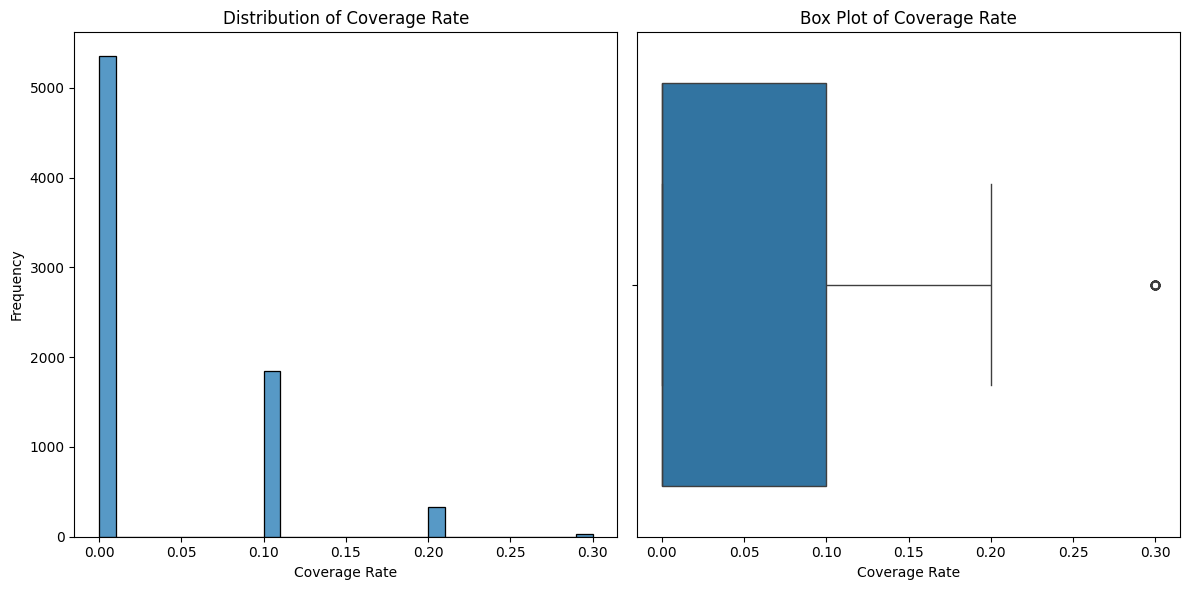

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Histogram of Coverage Rate
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(results_train['Coverage_Rate'])
plt.title('Distribution of Coverage Rate')
plt.xlabel('Coverage Rate')
plt.ylabel('Frequency')

# Box Plot of Coverage Rate
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x=results_train['Coverage_Rate'])
plt.title('Box Plot of Coverage Rate')
plt.xlabel('Coverage Rate')
plt.tight_layout()
plt.show()
